# ChemspaceSampler

- How many molecules can be found in chemical space as a function of representation distance (from a point in chemical space)?
- Does this number correlate with machine learning molecular properties?
- Is it possible to predict the density of molecules (in chemical space) around a query molecule? **SPOILER: YES it is!!!**
- I study this using Konstantin's MC code and will try to link the prediction error for a molecule to the number of molecules around a central molecule in chemical space (work in progress)

First example: distaces between representation of molecules
- Use RDKit to generate ECFP4 representations of molecules $X_1, X_2$
- Distance between two molecules defined as $d = ||X_1 - X_2||_2$

Play with it! As you change the smiles string, the 2D representation of the molecule changes. By that you also increase or decrease the distance `d` between the molecules.

In [8]:
#First we import some libraries that we will use in this tutorial
import numpy as np
import matplotlib.pyplot as plt

fs = 12
plt.rc("font", size=fs)
plt.rc("axes", titlesize=fs)
plt.rc("axes", labelsize=fs)
plt.rc("xtick", labelsize=fs)
plt.rc("ytick", labelsize=fs)
plt.rc("legend", fontsize=fs)
plt.rc("figure", titlesize=fs)

def make_pretty(axi):
    """
    Method to make the axes look pretty
    """
    axi.spines["right"].set_color("none")
    axi.spines["top"].set_color("none")
    axi.spines["bottom"].set_position(("axes", -0.05))
    axi.spines["bottom"].set_color("black")
    axi.spines["left"].set_color("black")
    axi.yaxis.set_ticks_position("left")
    axi.xaxis.set_ticks_position("bottom")
    axi.spines["left"].set_position(("axes", -0.05))
    return axi 

Next we define a potential that we will use to probe chemical space at a given target distance $d$. For the example given below we would be sampling molecules at distance between $d=2$ and $d=4$. For convinience we define a function that returns the potential above where $\epsilon=1.0$ controlls the depth of the potential and $\gamma$ and $\sigma$ the left and right position of the flat minimas. By setting $\gamma = 0.0$ and $\sigma = 1.5$ we sample all molecules at a maximal distance of 1.5 from the initial molecule. However, we can also sample specific distance intervals by setting $\gamma$ and $\sigma$ to the desired values. The potential is defined as

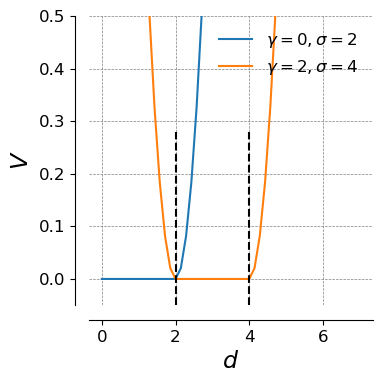

In [11]:
def flat_parabola_potential(d, gamma, sigma):
    """
    Flat parabola potential. Allows sampling within a distance basin
    interval of I in [gamma, sigma]. epsilon determines depth of minima
    and is typically set to epsilon = 5. The potential is given by:
    """
    if d < gamma:
        return (d - gamma) ** 2
    if gamma <= d <= sigma:
        return 0
    if d > sigma:
        return (d - sigma) ** 2 


epsilon = 0
gamma1,sigma1 = 0, 2.0
gamma2,sigma2 = 2, 4



fig1, ax1 = plt.subplots(figsize=(4,4))

dist = np.linspace(0,7)
y1 = [flat_parabola_potential(dval, gamma1, sigma1) for dval in dist]
y2 = [flat_parabola_potential(dval, gamma2, sigma2) for dval in dist]
ax1.grid(True, linestyle='--', linewidth=0.5, color='grey')

ax1.plot(dist, y1, label = r"$\gamma = 0, \sigma = 2$")
ax1.plot(dist, y2, label = r"$\gamma = 2, \sigma = 4$")
ax1.set_ylim(-0.05, 0.5)
ax1.axvline(x=2, ymin=0, ymax=0.6,color="black", linestyle="--")
ax1.axvline(x=4, ymin=0, ymax=0.6,color="black", linestyle="--")
make_pretty(ax1)


plt.xlabel('$d$', fontsize = fs+5)
plt.ylabel('$V$', fontsize = fs+5)
#make the plot look nice and tight
#add legend
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig(f"potential.pdf", dpi=300)
plt.show()

In [12]:
from mosaics.minimized_functions import chemspace_potentials
from mosaics.beta_choice import gen_exp_beta_array

params = {
    'min_d': 2.0,
    'max_d': 5.0,
    'strictly_in': True,
    'V_0_pot': 1,
    'V_0_synth': 0.05,
    'NPAR': 1,
    'Nsteps': 15,
    'bias_strength': "none",
    'possible_elements': ["C", "O", "N", "F"],
    'not_protonated': None, 
    'forbidden_bonds': [(8, 9), (8, 8), (9, 9), (7, 7)],
    'nhatoms_range': [13, 16],
    'betas': gen_exp_beta_array(4, 1.0, 32, max_real_beta=8.0),
    'make_restart_frequency': None,
    "rep_type": "2d",
    "nBits": 2048,
    'synth_cut_soft':2,
    'synth_cut_hard':5,
    'rep_name': 'ECFP',
    'mmff_check': True, 
    "verbose": False}

MOLS, D = chemspace_potentials.chemspacesampler_ECFP(smiles="CC(=O)OC1=CC=CC=C1C(=O)O", params=params)    


In [13]:
MOLS

array(['CC(=O)Oc1cc(C)ccc1C(=O)O', 'CC(=O)Oc1ccc(C)cc1C(=O)O',
       'O=C(CO)Oc1ccccc1C(=O)O', 'C=C(C)Oc1ccccc1C(=O)O',
       'NC(=O)Oc1ccccc1C(=O)O'], dtype='<U24')

Ok so lets do this! We start with `"CCO"` as the intial molecule and sample molecules at distance `d` between 2 and 4. 
The MC alorigthm will propose new candidates and accept or reject them based on the potential defined above.
We will use the potential defined above. Change the values for `gamma` and `sigma` see how this affects the printed output. The script prints


`smiles, distance, potential`

You can also play with the constraints

Next, we load the results konverting Konstantins trajectoty random work points to SMILES

Now we visualize the results. We plot a UMAP projection of the sampled molecules and color them by the distance to the initial molecule. 

Text(0.5, 1.0, 'UMAP histogram of encountered molecules')

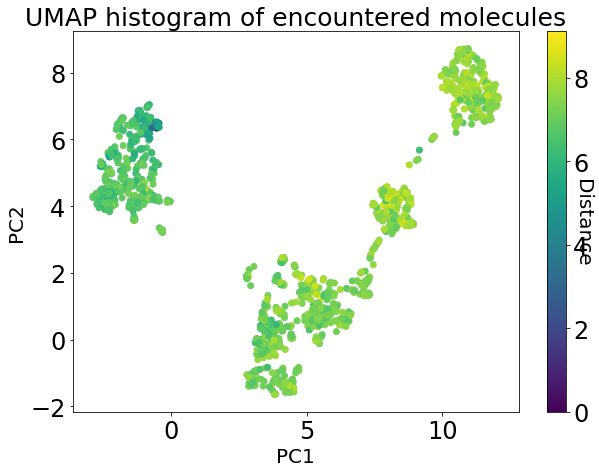

In [11]:
#plot the pca
plt.figure(figsize=(10,7))
plt.scatter(X_2d[:,0], X_2d[:,1], c=distances_explored, cmap="viridis")

cbar = plt.colorbar()
cbar.set_label('Distance', rotation=270, fontsize=20)
plt.xlabel("PC1", fontsize=20)
plt.ylabel("PC2", fontsize=20)
plt.title("UMAP histogram of encountered molecules", fontsize=25)

Let us have a closer look at the 10 molecues closest to our inital molecule and the 10 molecules furthest away. We will use the RDKit to generate 2D representations of the molecules and plot them.

In [12]:
order_explored = np.argsort(distances_explored)

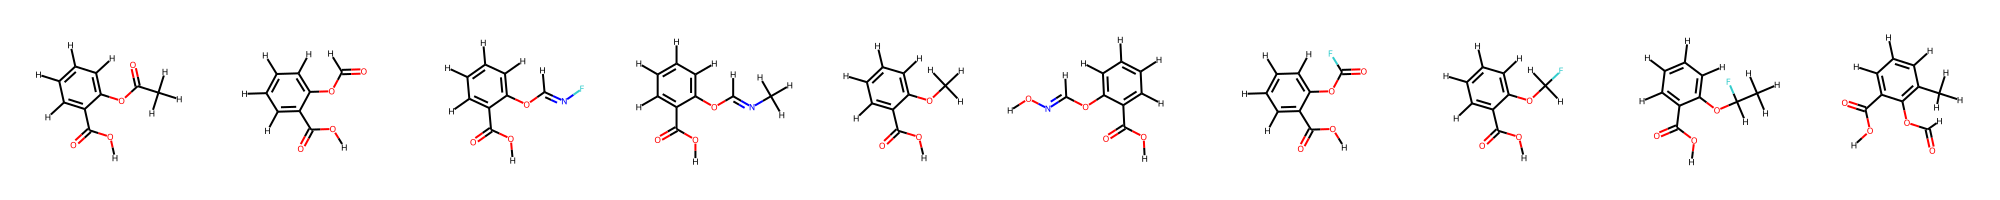

In [13]:
Draw.MolsToGridImage(explored_rdkit[order_explored][:10], molsPerRow=10)  

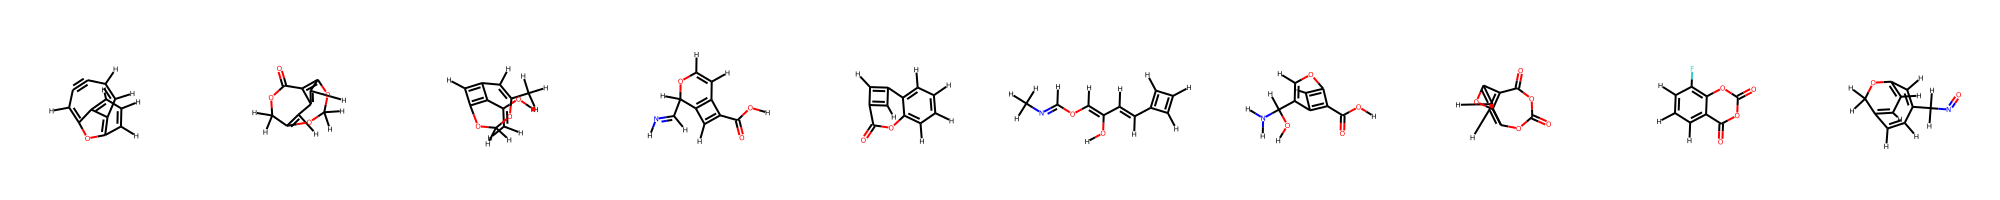

In [14]:
Draw.MolsToGridImage(explored_rdkit[order_explored[::-1]][:10], molsPerRow=10)  